In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

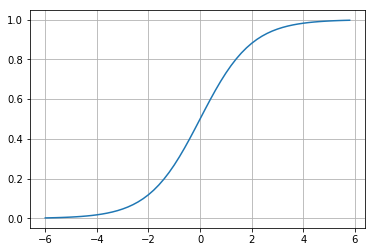

In [2]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

a = np.arange(-6, 6, 0.2)
plt.plot(a, [ sigmoid(x) for x in a ])
plt.grid()
plt.show()

Hypothesis from linear regression: $z_\theta(x) = \theta_0x_0 + \theta_1x_1 \dots + \theta_nx_n = \theta^Tx$

In [3]:
def z(theta, x):
    assert theta.shape[1] == 1
    assert theta.shape[0] == x.shape[1]  # Theta should have as many rows as x has features.
    return np.dot(x, theta)

bt = np.atleast_2d([0, 0]).T
bx = np.atleast_2d([1, 1])
print("Theta for two features:\n", bt)
print("X with one sample for two features:\n", bx)
bz = z(bt, bx)
print(bz)
assert bz == np.atleast_2d(0)
assert bz.shape == (1, 1)
print()

bt = np.atleast_2d([1, 2]).T
bx = np.atleast_2d([1, 1])
print("Theta for two features:\n", bt)
print("X with one sample for two features:\n", bx)
bz = z(bt, bx)
print(bz)
assert bz == np.atleast_2d(3)
assert bz.shape == (1, 1)
print()

bt = np.atleast_2d([1, 2]).T
bx = pd.DataFrame({ 'x': [1, 2], 'y': [4, 3] }).values
print("Theta for two features:\n", bt)
print("X with two samples for two features:\n", bx)
bz = z(bt, bx)
print(bz)
assert bz.shape == (2, 1)  # Two rows, one for each sample.

Theta for two features:
 [[0]
 [0]]
X with one sample for two features:
 [[1 1]]
[[0]]

Theta for two features:
 [[1]
 [2]]
X with one sample for two features:
 [[1 1]]
[[3]]

Theta for two features:
 [[1]
 [2]]
X with two samples for two features:
 [[1 4]
 [2 3]]
[[9]
 [8]]


Logistic hypothesis from composition of sigmoid/logistic function and linear hypothesis:
$$h_\theta(x) = \frac{1}{1 + e^{-z_\theta(x)}} = \frac{1}{1 + e^{-\theta^Tx}}$$

In [4]:
def hypothesis(theta, x):
    return sigmoid(z(theta, x))

bt = np.atleast_2d([0, 0]).T
print(bt)
bz = hypothesis(bt, np.atleast_2d([1000, 1000]))
print(bz)
assert bz.shape == (1, 1)
assert bz == np.atleast_2d(0.5)

bt = np.atleast_2d([0, 1]).T  # Two features.
bx = pd.DataFrame({ 'x': [1, 1, 1], 'y': [1, 2, 3] }).values  # Three samples.
bz = hypothesis(bt, bx)
print(bz)
assert bz.shape == (3, 1)  # Three samples.
assert bz[0] < bz[1]
assert bz[1] < bz[2]

[[0]
 [0]]
[[ 0.5]]
[[ 0.73105858]
 [ 0.88079708]
 [ 0.95257413]]


The logistic hypothesis tells us the probability of an $x$ being $1$ for the given $\theta$.
$$h_\theta(x) = P(y = 1 \,|\, x ; \theta) = 1 - P(y = 0 \,|\, x ; \theta)$$

We choose to predict that $y = 1$ when $h_\theta(x) \ge 0.5$. `sigmoid(x)` returns $ \ge 0.5$ for values $x \ge 0$. Thus we can predict $y = 1$ when $\theta^Tx \ge 0$.

We cannot use the cost function from linear regression with this hypothesis since it would produce local minima. Instead given `m` samples:

\begin{align*}
J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \text{Cost}(h_\theta(x^{(i)}), y^{(i)}) \\
\text{Cost}(h_\theta(x^{(i)}), 1) &= -\log(h_\theta(x)) \\
\text{Cost}(h_\theta(x^{(i)}), 0) &= -\log(h_\theta(1 - x))
\end{align*}

This way we get a higher penalty the further the hypothesis is from `y` no matter if `y` is `1` or `0`.

This can be simplified with a vectorized implementation and with the conditionals removed:

$$
J(\theta) = \frac{1}{m} \dot (-y^{T}\log(h_\theta(x)) - (1 - y)^{T} \log(1 - h_\theta(x)))
$$

In [5]:
def cost(theta, x, y):
    assert x.shape[1] == theta.shape[0]  # x has a column for each feature, theta has a row for each feature.
    assert x.shape[0] == y.shape[0]  # One row per sample.
    assert y.shape[1] == 1
    assert theta.shape[1] == 1
    h = hypothesis(theta, x)
    one_case = np.matmul(-y.T, np.log(h))
    zero_case = np.matmul(-(1 - y).T, np.log(1 - h))
    return (one_case + zero_case) / len(x)

In [6]:
# Simple case, two features, one sample.
cx = pd.DataFrame({ 'b': [1], 'x': [1] }).values
ct = np.atleast_2d([ 1, 1 ]).T
cy = np.atleast_2d([ 1 ]).T
print(ct.shape, cx.shape, cy.shape, len(cx))
cc = cost(ct, cx, cy)
print(cc)
assert cc.shape == (1, 1)

(2, 1) (1, 2) (1, 1) 1
[[ 0.12692801]]


In [7]:
# Two features, three samples.
cx = pd.DataFrame({ 'b': [0, 1, 2], 'x': [0, 1, 2] }).values
ct = np.atleast_2d([ 8, 10 ]).T      # Two features, two rows.
cy = np.atleast_2d([ 1, 1, 1 ]).T    # Three samples, three rows.
print(ct.shape, cx.shape, cy.shape, len(cx))
print(cost(ct, cx, cy))

(2, 1) (3, 2) (3, 1) 3
[[ 0.23104907]]


In [8]:
# Simple case, two features, one sample, y = 0.
cx = pd.DataFrame({ 'b': [1], 'x': [0] }).values
ct = np.atleast_2d([ 1, 0 ]).T
cy = np.atleast_2d([ 0 ]).T
print(ct.shape, cx.shape, cy.shape, len(cx))
print(cost(ct, cx, cy))

(2, 1) (1, 2) (1, 1) 1
[[ 1.31326169]]


In [9]:
def gradient_descent(theta, x, y, learning_rate):
    error = hypothesis(theta, x) - y
    n = (learning_rate / len(x)) * np.matmul(x.T, error)
    return theta - n

In [10]:
gx = pd.DataFrame({ 'b': [0], 'x': [0] })
gy = np.atleast_2d([ 0 ]).T
gt = np.atleast_2d([ 0, 0 ]).T
gradient_descent(gt, gx, gy, 0.0005), cost(gt, gx, gy)

(array([[ 0.],
        [ 0.]]), array([[ 0.69314718]]))

In [11]:
def minimize(theta, x, y, iterations, learning_rate):
    costs = []
    for _ in range(iterations):
        theta = gradient_descent(theta, x, y, learning_rate)
        costs.append(cost(theta, x, y)[0][0])
    return theta, costs

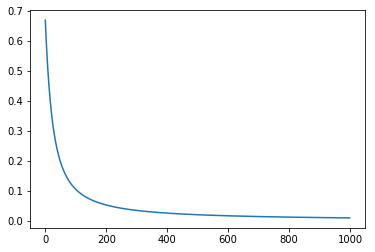

,0
0,-4.570828


In [12]:
gx = pd.DataFrame({ 'b': [1], 'x': [1] })
gy = np.atleast_2d([ 0 ]).T
gt = np.atleast_2d([ 0, 0 ]).T

theta, costs = minimize(gt, gx, gy, 1000, 0.05)
plt.plot(range(len(costs)), costs)
plt.show()

gx.dot(theta)

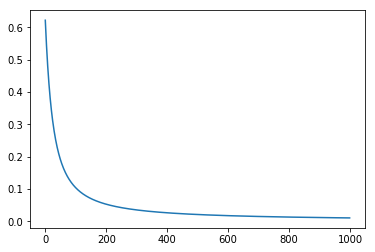

,0
0,4.572902


In [13]:
gx = pd.DataFrame({ 'b': [1], 'x': [1] })
gy = np.atleast_2d([ 1 ]).T
gt = np.atleast_2d([ 0.05, 0.05 ]).T

theta, costs = minimize(gt, gx, gy, 1000, 0.05)
plt.plot(range(len(costs)), costs)
plt.show()

gx.dot(theta)

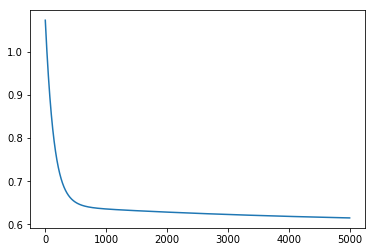

candidate =  [[ 1.48091987]
 [-0.25966117]
 [ 0.20362199]]
cost = 0.614971640354
accuracy =  0.6825


In [14]:
data = pd.read_csv("logistic_regression_data.csv")
x = np.column_stack((np.ones(len(data)), data.loc[:,['gpa', 'rank']].values))
y = np.atleast_2d(data['admit'].values).T
candidate = np.atleast_2d([ np.random.uniform(-4, 4, 3) ]).T
theta, costs = minimize(candidate, x, y, 5000, 0.0008)
plt.plot(range(len(costs)), costs)
plt.show()
print("candidate = ", candidate)
print("cost =", costs[-1])

predictions = x.dot(theta)
results = zip(predictions[:,0] > 0, map(bool, (y[:,0])))
print("accuracy = ", len(list(filter(lambda x: x[0] == x[1], results))) / len(predictions))

In [15]:
data = pd.read_csv("logistic_regression_data.csv")
x = np.column_stack((np.ones(len(data)), data.loc[:,['gpa', 'rank']].values))
y = np.atleast_2d(data['admit'].values).T

results = []
for _ in range(1):
    candidate = np.atleast_2d([ np.random.uniform(-4, 4, 3) ]).T
    theta, costs = minimize(candidate, x, y, 6000, 0.0008)
    
    predictions = x.dot(theta)
    cmps = zip(predictions[:,0] > 0, map(bool, (y[:,0])))
    accuracy = len(list(filter(lambda x: x[0] == x[1], cmps))) / len(predictions)
    if accuracy > 0.71:
        print(accuracy, costs[-1], candidate[:,0])
        results.append((accuracy, costs[-1], candidate))
        
results

[]

Hall of fame:

- 6000/0.0008 0.725 0.580182265246 [-3.03836764 -1.35464218 -1.97743099]
- 6000/0.0008 0.73 0.581455360207 [-3.62543456  1.82863319 -0.38542527]
- 6000/0.0008 0.735 0.579989153107 [-2.20285257  2.84503643  0.79073498]

In [16]:
regression = LogisticRegression()
regression.fit(x, y[:,0])
regression.score(x, y[:,0])

0.71750000000000003

In [17]:
mushroom_data = pd.read_csv("mushrooms.csv").dropna()
mushroom_x = pd.get_dummies(mushroom_data.drop('class', axis=1))
mushroom_x['bias'] = 1
mushroom_x = mushroom_x.values
mushroom_y = (np.atleast_2d(mushroom_data['class']).T == 'p').astype(int)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(mushroom_x, mushroom_y, train_size=0.9, test_size=0.1)
mushroom_regression = LogisticRegression()
mushroom_regression.fit(x_train, y_train[:,0])
mushroom_regression.score(x_test, y_test[:,0])

1.0

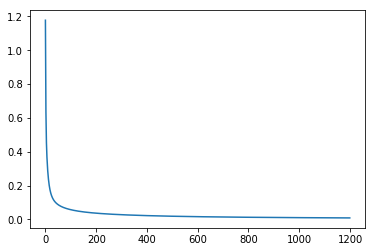

0.00894269213352


In [30]:
candidate = np.atleast_2d([ np.random.uniform(-1, 1, 118) ]).T
theta, costs = minimize(candidate, x_train, y_train, 1200, 1)
plt.plot(range(len(costs)), costs)
plt.show()
print(costs[-1])

In [31]:
predictions = x_test.dot(theta) > 0
len(list(filter(lambda x: x[0] == x[1], np.dstack((predictions, y_test))[:,0]))) / len(predictions)

0.998769987699877